# **Cotton_plant_disease_detection_model**

## **1-Import Libraries**

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

## **2-Import and Load Helper Functions**

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-03-28 18:02:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-03-28 18:02:17 (61.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import compare_historys, confusion_matrix, create_tensorboard_callback, plot_loss_curves , pred_and_plot

## **3-Load Dataset From Google Drive**

In [4]:
import zipfile

# unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/cotton_disease_dataset.zip")
zip_ref.extractall()
zip_ref.close()

## **4-Train,Test and Validation Paths**

In [5]:
train_dir = '/content/Cotton Disease/train'
test_dir = '/content/Cotton Disease/test'
val_dir = '/content/Cotton Disease/val'

## **5-Show Augmented Images**

In [6]:
# show augmented images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

## **6-Data Augmentation**

In [7]:
# this is the augmentation configuration we will use for training
# It generate more images using below parameters
training_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

# this is a generator that will read pictures found in
# at train_data_path, and indefinitely generate
# batches of augmented image data
training_data = training_datagen.flow_from_directory(train_dir, # this is the target directory
                                      target_size=(150, 150), # all images will be resized to 150x150
                                      batch_size=32,
                                      class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

Found 1951 images belonging to 4 classes.


In [8]:
training_data.class_indices

{'diseased cotton leaf': 0,
 'diseased cotton plant': 1,
 'fresh cotton leaf': 2,
 'fresh cotton plant': 3}

In [9]:
# this is the augmentation configuration we will use for validation:
# only rescaling
valid_datagen = ImageDataGenerator(rescale=1./255)

# this is a similar generator, for validation data
valid_data = valid_datagen.flow_from_directory(val_dir,
                                  target_size=(150,150),
                                  batch_size=32,
                                  class_mode='binary')

Found 253 images belonging to 4 classes.


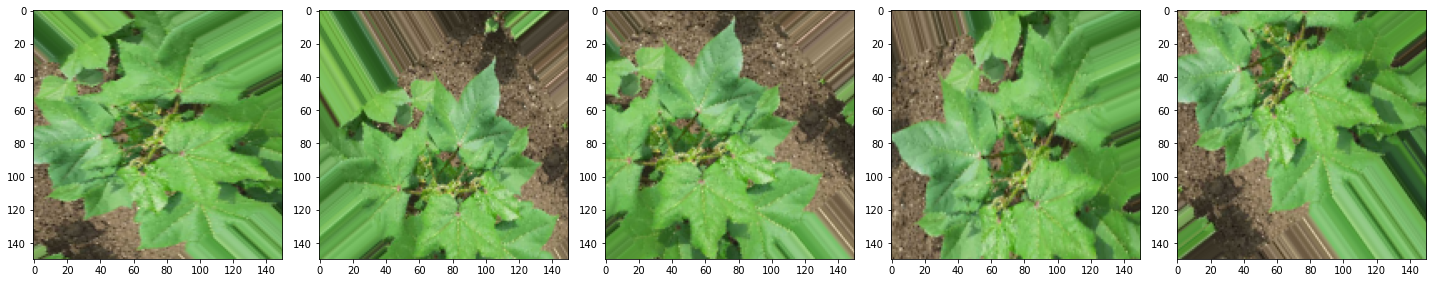

In [10]:
# showing augmented images
images = [training_data[0][0][0] for i in range(5)]
plotImages(images)

## **7-Save Best Model Using Validation_Accuracy**

In [11]:
# save best model using vall accuracy
model_path = '/content/drive/MyDrive/cotton_plant_disease_detection_model.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

## **8-Build CNN Model**

In [12]:
cnn_model = keras.models.Sequential([
                                    keras.layers.Conv2D(filters=32, kernel_size=3, input_shape=[150, 150, 3]),
                                    keras.layers.MaxPooling2D(pool_size=(2,2)),
                                    keras.layers.Conv2D(filters=64, kernel_size=3),
                                    keras.layers.MaxPooling2D(pool_size=(2,2)),
                                    keras.layers.Conv2D(filters=128, kernel_size=3),
                                    keras.layers.MaxPooling2D(pool_size=(2,2)),                                    
                                    keras.layers.Conv2D(filters=256, kernel_size=3),
                                    keras.layers.MaxPooling2D(pool_size=(2,2)),

                                    keras.layers.Dropout(0.5),                                                                        
                                    keras.layers.Flatten(), # neural network beulding
                                    keras.layers.Dense(units=128, activation='relu'), # input layers
                                    keras.layers.Dropout(0.1),                                    
                                    keras.layers.Dense(units=256, activation='relu'),                                    
                                    keras.layers.Dropout(0.25),                                    
                                    keras.layers.Dense(units=4, activation='softmax') # output layer
])


# compile cnn model
cnn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [13]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

## **9-Train and Evaluate The Model**

In [14]:
# train cnn model
history = cnn_model.fit(training_data, 
                          epochs=250, 
                          verbose=1, 
                          validation_data= valid_data,
                          callbacks=callbacks_list) 

Epoch 1/250
61/61 [==============================] - ETA: 0s - loss: 1.2511 - accuracy: 0.4408
Epoch 1: val_accuracy improved from -inf to 0.45455, saving model to /content/drive/MyDrive/cotton_plant_disease_detection_model.h5
61/61 [==============================] - 37s 445ms/step - loss: 1.2511 - accuracy: 0.4408 - val_loss: 1.1519 - val_accuracy: 0.4545
Epoch 2/250
61/61 [==============================] - ETA: 0s - loss: 1.0834 - accuracy: 0.5423
Epoch 2: val_accuracy improved from 0.45455 to 0.64427, saving model to /content/drive/MyDrive/cotton_plant_disease_detection_model.h5
61/61 [==============================] - 26s 431ms/step - loss: 1.0834 - accuracy: 0.5423 - val_loss: 0.9284 - val_accuracy: 0.6443
Epoch 3/250
61/61 [==============================] - ETA: 0s - loss: 0.9595 - accuracy: 0.6064
Epoch 3: val_accuracy did not improve from 0.64427
61/61 [==============================] - 26s 427ms/step - loss: 0.9595 - accuracy: 0.6064 - val_loss: 0.9241 - val_accuracy: 0.6126
E

In [15]:
cnn_model.evaluate(valid_data)

8/8 [==============================] - 2s 228ms/step - loss: 0.0891 - accuracy: 0.9605


[0.08908484131097794, 0.9604743123054504]

## **10-Save The Model**

In [16]:
cnn_model.save('/content/drive/MyDrive/cotton_plant_disease_detection_model.h5')

## **11-Plot The Graph**

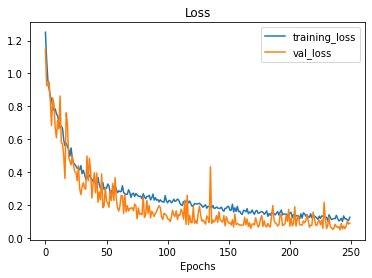

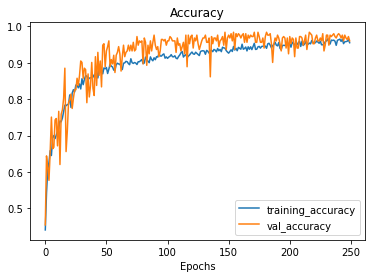

In [17]:
plot_loss_curves(history)